In [18]:
using Pkg; Pkg.activate("..");

using StochasticFrontiers;

  Activating project at `~/Documents/project/StochasticFrontiers.jl`


In [2]:
res = sfmodel_fit(
    spec = sfspec(
        data       = "data/SNCreData.csv",
        model      = SNCre(), 
        type       = Prod(), 
        dist       = Half(σᵤ² = :_cons), 
        σᵥ²        = :_cons, 
        ivar       = :i, 
        depvar     = :log_y, 
        frontiers  = (:log_x1, :log_x2, :t), 
        serialcorr = AR(1), 
        R          = 250, 
        σₑ²        = :_cons,
        verbose    = false
    ),
    options = sfopt(
        warmstart_solver = nothing, 
        main_solver      = Optim.NewtonTrustRegion()
    ), 
    init = sfinit([
        0.5227960098102571,        # coefficient of explanatory variables
        0.1868939866287993,        # coefficient of explanatory variables
        0.007442174221837823,      # coefficient of time effect
        -1.6397116052113527*2,     # log_σᵤ²
        -3.3244812689250423*2,     # log_σᵥ²
        0.3484365793340449,        # coefficient of fixed effect(mean of x1)
        -0.05768082007032795,      # coefficient of fixed effect2(mean of x2)
        -0.5943654485109733/14.5,  # costant term of fixed effect3(mean of x3)
        -0.8322378217931871*2,     # log_σₑ²
        0.,
    ])
);


*********************************
      Model Specification      
*********************************

    flexible panel stochastic frontier model with serially correlated errors

    Yᵢₜ = αᵢ + Xᵢₜ*β + T*π + ϵᵢₜ
        where αᵢ = δ₀ + X̄ᵢ'* δ₁ + eᵢ,

        and since the serial correlated assumptions is AR1,
            ϵᵢₜ = ϕ1 * ϵᵢₜ₋1  + ηᵢₜ
            ηᵢₜ = vᵢₜ - uᵢₜ

        further,     
            vᵢₜ ∼ N(0, σᵥ²),
            σᵥ²  = exp(log_σᵥ²)

            uᵢₜ ∼ N⁺(0, σᵤ²),
            σᵤ² = exp(log_σᵤ²)

            eᵢ ∼ N(0, σₑ²)
            σᵤ² = exp(log_σₑ²)

    In the case of type(cost), "- uᵢₜ" above should be changed to "+ uᵢₜ"

*********************************
        Estimation Results 
*********************************

 Converge:                   false (|g| > gtol but f, x converge)
 Log-likelihood Value:       3531.74644

 Number Of Total Iterations: 24
 Time Consuming:             40.9548
 Numberf Of Observations:    2296

┌───────────┬─────────────┬───────

In [3]:
sfcheck_converge(res)

 * Status: failure

 * Candidate solution
    Final objective value:     -3.531746e+03

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.17e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   41  (vs limit Inf)
    Iterations:    24
    f(x) calls:    25
    ∇f(x) calls:   25
    ∇²f(x) calls:  18



In [4]:
options = sfoptions(res)
Dict{Symbol, Any}(zip(keys(options), values(options)))

Dict{Symbol, Any} with 8 entries:
  :show_trace       => false
  :verbose          => true
  :table_format     => :text
  :warmstart_solver => nothing
  :tolerance        => 1.0e-8
  :warmstart_maxIT  => 100
  :main_maxIT       => 2000
  :main_solver      => NewtonTrustRegion{Float64}(1.0, 100.0, 1.49012e-8, 0.1, …

In [5]:
# initial and the MLE
[sfmodel(res).paramnames  sfstartpt(res) sfmaximizer(res)]

10×4 Matrix{Any}:
 :frontiers  :log_x1        0.522796     0.599281
 Symbol("")  :log_x2        0.186894     0.0207547
 Symbol("")  :t             0.00744217  -0.01514
 :log_σᵤ²    :_cons        -3.27942     -5.67875
 :log_σᵥ²    :_cons        -6.64896     -6.70602
 :αᵢ         :mean_log_x1   0.348437     0.26721
 Symbol("")  :mean_log_x2  -0.0576808    0.0905024
 Symbol("")  :mean_t       -0.0409907    0.146961
 :log_σₑ²    :_cons        -1.66448     -3.29032
 :ϕ          :ϕ1            0.0          0.973058

In [6]:
[["AIC", "BIC"] [sfAIC(res), sfBIC(res)]]

2×2 Matrix{Any}:
 "AIC"  -7053.49
 "BIC"  -6986.1

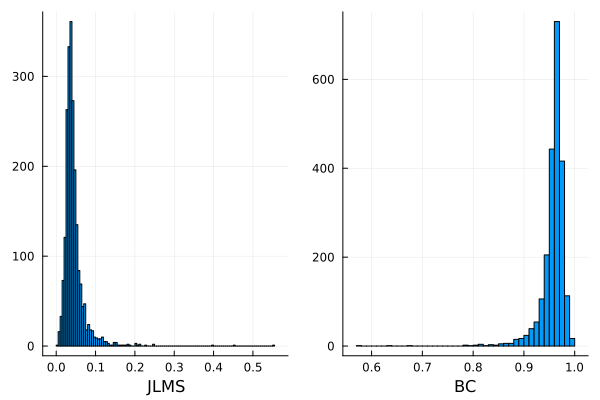

In [7]:
plot_inefficieny(res)

## Monte Carlo Study

In [23]:
using Distributions, Random, ProgressMeter


function simulate_ϵ_ar1(v, u; ϕ, ϵ0 = 0.)
    T = length(v)
    η    = v - u
    ϵ    = similar(v, T+1)
    ϵ[1] = ϵ0
    
    for i = 2 : (T+1)
        ϵ[i] = ϵ[i-1]*ϕ + η[i-1]
    end
    
    return ϵ[2:end]
end


function simulate_ϵ_ma1(v, u; θ,  η0 = nothing)
    T         = length(v)
    diff      = v - u
    η         = similar(v, T+1)
    η[1]      = η0 isa Nothing ? mean(diff) : η0
    η[2:end]  = diff
    ϵ         = similar(v, T)
    
    for i = 2 : (T+1)
        ϵ[i-1] = η[i] + η[i-1]*θ
    end 
    
    return ϵ
end



function DGP(N, T, ϵ_formula, σᵥ, σᵤ, σα², τ, β)
    
    X = Matrix{Float64}(undef, N*T, 1)
    y = Vector{Float64}(undef, N*T)
    
    start = 1
    for i = 1:N
        terminate = start + T - 1
        
        v = rand(Normal(0, σᵥ), 2T)
        u = rand(Normal(0, σᵤ), 2T)
        ϵ = ϵ_formula(v, u)
        
        α  = repeat(rand(Normal(0, sqrt(σα²)), 1), outer = 2T)
        _X = τ*α + sqrt(1-τ^2)*randn(2T, 1)
        _y = α + _X*β + ϵ
        
        y[start:terminate]    = _y[T+1:end]
        X[start:terminate, 1] = _X[T+1:end, 1]
        
        start = terminate + 1
    end
    
    return y, X
end


function mone_carlo_simulation(replications, 
                               N, 
                               T, 
                               ϵ_formula; 
                               σᵥ   = 0.7, 
                               σᵤ   = sqrt(2)*0.7, 
                               σα²  = 0.5, 
                               τ    = 0.5, 
                               β    = [0.8],
                               seed = 1126,
                               gtol = 1e-4
                              )
    _cons = ones(N*T)
    ivar  = reduce(vcat, [repeat([i], T) for i = 1:N])
    
    sim_res = Matrix{Float64}(undef, 4, replications)
    p       = Progress(replications, desc = "Resampling: ", color = :white, barlen = 30)
    i       = 1
    
    while i <= replications
        y, X  = DGP(N, T, ϵ_formula, σᵥ, σᵤ, σα², τ, β)
        res = try
            sfmodel_fit(
                spec = sfspec(
                    model      = SNCre(), 
                    type       = Prod(), 
                    dist       = Half(σᵤ² = _cons), 
                    σᵥ²        = _cons, 
                    ivar       = ivar, 
                    depvar     = y, 
                    frontiers  = X, 
                    serialcorr = AR(1), 
                    R          = 250, 
                    σₑ²        = _cons,
                    verbose    = false
                ),
                options = sfopt(
                    warmstart_solver = nothing,
                    verbose          = false,
                ), 
                init = sfinit(
                    frontiers = β, 
                    log_σᵤ²   = log(σᵤ^2), 
                    log_σᵥ²   = log(σᵥ^2),
                    ϕ         = 0.4
                )
            )
        catch
            continue
        end
        
        # small tolerance can be slow
        valid    = Optim.g_residual(res.main_res.fit_res) <= gtol
        converge = Optim.converged(res.main_res.fit_res)
        
        if valid && converge
            ξ             = sfmaximizer(res)[[1, 2, 3, 7]]
            ξ[2]          = sqrt(exp(ξ[2]))
            ξ[3]          = sqrt(exp(ξ[3]))
            sim_res[:, i] = ξ
        else
            continue
        end
        
        i += 1; next!(p)
    end
    
    return sim_res
end

mone_carlo_simulation (generic function with 1 method)

In [24]:
ϵ_formula = (v, u) -> simulate_ϵ_ar1(v, u, ϕ = 0.4)

sim_res1 = mone_carlo_simulation(1000, 100, 10, ϵ_formula);

Resampling: 100%|██████████████████████████████| Time: 1:25:17


In [25]:
truth    = [0.8, sqrt(2)*0.7, 0.7, 0.4]
bias     = mean(sim_res1, dims = 2)[:, 1] - truth
variance = var(sim_res1, dims = 2)
mse      = mean((sim_res1 .- true).^2, dims = 2)[:, 1]

[["β", "σᵤ", "σᵥ", "ϕ"] bias variance mse]

4×4 Matrix{Any}:
 "β"   -0.00273772  1.92531e-6   0.0411045
 "σᵤ"  -0.0887066   0.000813645  0.0105658
 "σᵥ"   0.389244    1.28725e-5   0.00797735
 "ϕ"    0.0208733   8.19328e-7   0.335389

In [26]:
sim_res1

4×1000 Matrix{Float64}:
 0.753428     0.797306  0.797306  0.797306  …  0.797306  0.797306  0.797306
 0.000122336  0.902145  0.902145  0.902145     0.902145  0.902145  0.902145
 1.20259      1.08913   1.08913   1.08913      1.08913   1.08913   1.08913
 0.392278     0.420902  0.420902  0.420902     0.420902  0.420902  0.420902